# Heat Transfer through a Window
This notebook produces probability density functions of heat transfer through a window using Monte Carlo sampling, full quadrature, and sparse quadrature. It also produces a graph of the spectral decay of the polynomial chaos expansion coefficients.
One may choose whether the model has 1 pane or 2 and whether radiative heat transfer is considered.

In [1]:
#general imports
from __future__ import print_function

try:
    import numpy as np
except ImportError:
    print("Numpy module could not be found")

try:
    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('mathtext', default='regular')
except ImportError:
    print("Matplotlib not found")

try:
    from scipy import stats
except ImportError:
    print("Scipy stats module could not be found")

try:
    import PyUQTk.pce as uqtkpce
except ImportError:
    print("PyUQTk PCE module not found")
    
try:
    import PyUQTk.PyPCE.pce_tools as pce_tools
except ImportError:
    print("PyUQTk pce_tools module not found")

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


In [2]:
#problem-specific imports
try:
    from window_combo_tools import *
except ImportError:
    print("File with PCE utilities not found.")

## Setting input arguments

Choose between 3 models:
1. single-pane window
2. double-pane window with 5 uncertain parameters
3. double-pane window with 12 uncertain parameters (Warning: keep nord low, best is <2.)

In [3]:
model = 3           # Which model to use
main_verbose = 0    # Set to 1 for intermediate print statements, otherwise set to 0
compute_rad = False # Whether to include radiation calculations
nord = 2            # Order of the PCE
pc_type = "LU"      # Polynomial type
pc_alpha = 0.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0       # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
param = nord +1     # Number of quadrature points per dimension for full quadrature or level for sparse quadrature
n_MC = 100000       # Number of random samples

#### Model 1 inputs

In [4]:
if (model==1):
    
    # Nominal values of the parameters used to calculate the heat flux
    Ti = 293.0 # Room temperature in K
    To = 273.0 # Outside temperature in K
    dw = 0.01  # Window thickness in m
    kw = 1.0   # Window conductivity in W/mK
    hi = 2.0   # Inner convective heat transfer coefficient in W/m^2K
    ho = 6.0   # Outer wall convective heat transfer coefficient in W/m^2K
    TA = 150.0 # Atmospheric temperature in K. Only used to calculate heat flux when it is assumed that radiative heat transfer occurs

    # Set the standard deviations of the Gaussian uncertainty of these uncertain parameters
    std_Ti=Ti*0.005
    std_To=To*0.005
    std_dw=dw*0.01
    std_kw=kw*0.05
    std_hi=hi*0.15
    std_ho=ho*0.15
    std_TA=TA*0.1

    # Set number of dimensions of the PCE (number of uncertain variables)
    if compute_rad:
        ndim = 7
    else:
        ndim = 6
    
    # Create arrays of parameters
    p=[Ti,To,dw,kw,hi,ho]
    std_p=[std_Ti, std_To, std_dw, std_kw, std_hi, std_ho]
    if compute_rad:
        p.append(TA)
        std_p.append(std_TA)

#### Model 2 inputs

In [5]:
if (model==2):
    
    # The uncertain, Gaussian parameters used to calculate the heat flux
    Ts = 200.0 # Sky temperature (K) #new
    hi = 2.0   # Coefficient of convection inside (W/m^2*s)
    ho = 6.0   # Coefficient of convection outside (W/m^2*s)
    kw = 1.0   # Conduction constant for glass (W/m*K)
    ka = 0.024 # Conduction constant for air (W/m*K) 
    
    # Set standard deviations of these uncertain parameters
    std_Ts=Ts*0.1
    std_hi=hi*0.15
    std_ho=ho*0.15
    std_kw=kw*0.05
    std_ka=ka*0.05

    # Set number of dimensions of the PCE (number of uncertain variables)
    ndim=5
    
    # Create arrays of parameters
    p=[Ts,hi,ho,kw,ka] 
    std_p=[std_Ts, std_hi, std_ho, std_kw, std_ka]

#### Model 3 inputs

In [6]:
if (model==3):
    # The uncertain, Gaussian parameters used to calculate the heat flux
    Ti = 293.0   # Room temperature (K)
    To = 273.0   # Outside temperature (K)
    dw = 0.005   # Width of the glass pane (m)
    da = 0.01    # Width of the gap between the panes (m)
    kw = 1.0     # Conduction constant for glass (W/m*K)
    ka = 0.024   # Conduction constant for air (W/m*K)
    hi = 2.0     # Coefficient of convection inside (W/m^2*s)
    ho = 6.0     # Coefficient of convection outside (W/m^2*s)
    Ts = 200.0   # Sky temperature (K)
    mu = 1.86e-5 # Viscosity of air (kg/m*s)
    rho = 1.29 # Density of air (kg/m^3)
    beta = 3.67e-3 # Coefficient of thermal exspansion (1/K)

    # Set the standard deviations of these uncertain parameters
    std_Ti=Ti*0.005
    std_To=To*0.01
    std_dw=dw*0.01
    std_da=da*0.01
    std_kw=kw*0.05
    std_ka=ka*0.05
    std_hi=hi*0.15
    std_ho=ho*0.15
    std_Ts=Ts*0.1
    std_mu=mu*0.05
    std_rho=rho*0.05
    std_beta=beta*0.05

    # Set number of dimensions of the PCE (number of uncertain variables)
    ndim=12
    
    # Create arrays of parameters
    p=[Ti,To,dw,da,kw,ka,hi,ho,Ts,mu,rho, beta] 
    std_p=[std_Ti,std_To,std_dw,std_da,std_kw,std_ka,std_hi,std_ho,std_Ts,std_mu,std_rho, std_beta] 

## Forward propagation using Monte Carlo sampling

In [7]:
# Generate random samples of the uncertain parameters
samples0=[0]*ndim
for i in range(ndim):
    samples0[i]=np.random.normal(p[i], std_p[i], n_MC)
    
# Evaluate Forward model for sampled parameters, computing the heat flux Q
    # Q_evals is an array of evaluations of the forward model 
Q_evals=fwd_model(samples0, model, compute_rad, main_verbose)

# Perform kernel density estimation on Q_evals
    # xpts_MC is an array of points at which the PDF was estimated
    # PDF_data_MC is an array of the corresponding estimated PDF values.
xpts_MC, PDF_data_MC= pce_tools.UQTkKDE(Q_evals)

## Forward Propagation using PCEs and full quadrature

In [8]:
#Instantiate PC Object with full quadrature methods
pc_model = uqtkpce.PCSet("NISPnoq", nord,ndim,pc_type, pc_alpha,pc_beta)
pc_model.SetQuadRule(pc_type, 'full', param)
npce = pc_model.GetNumberPCTerms() # Number of terms in the PCE

if main_verbose > 0:
    print("The number of terms in each PCE is", npce)
    print("Multi-index and norm squared for all terms:")
    pc_model.PrintMultiIndexNormSquared()
    
#Get NumPy array of quadrature points, qdpts
    #totquat is the total number of quad points
qdpts, totquat= pce_tools.UQTkGetQuadPoints(pc_model)

# Convert Quadrature points in ξ_i to equivalent samples of input parameters
    # Since inputs are assumed to be Gaussian, we use parameter_samples = μ + σ(qdpts)
samples1=[0]*ndim
for p_i in range(ndim):
    samples1[p_i]=p[p_i]+std_p[p_i]*qdpts[:,p_i]
    
# Evaluate Forward model for sampled parameters, computing the heat flux Q
    # Q_evals is an array of evaluations of the forward model
Q_evals=fwd_model(samples1,model, compute_rad)

# Galerkin Projection to obtain PC coefficients
c_k = pce_tools.UQTkGalerkinProjection(pc_model,Q_evals)

# Generate germ samples
germ_samples=np.random.normal(0,1, (n_MC,ndim))

# Evaluate the PCE at the germ samples
pce_evals=pce_tools.UQTkEvaluatePCE(pc_model,c_k,germ_samples)

#Peform kernel density estimation
xpts_pce, PDF_data_pce = pce_tools.UQTkKDE(pce_evals)

## Forward propagation using PCEs and sparse quadrature

In [9]:
# Instantiate PC Object with sparse quadrature methods
pc_model2 = uqtkpce.PCSet("NISPnoq", nord,ndim,pc_type, pc_alpha,pc_beta)
pc_model2.SetQuadRule(pc_type, 'sparse', param)
npce2 = pc_model2.GetNumberPCTerms() # Number of terms in the PCE

if main_verbose > 0:
    print("The number of terms in each PCE is",npce2)
    print("Multi-index and norm squared for all terms:")
    pc_model2.PrintMultiIndexNormSquared()
    
#Get NumPy array of quadrature points, qdpts
    #totquat2 is the number of quad points
qdpts2, totquat2= pce_tools.UQTkGetQuadPoints(pc_model2)

# Convert Quadrature points in ξ_i to equivalent samples of input parameters
    # Since inputs are assumed to be Gaussian, we use parameter_samples = μ + σ(qdpts)
samples2=[0]*ndim
for p_i in range(ndim):
    samples2[p_i]=p[p_i]+std_p[p_i]*qdpts2[:,p_i]

# Evaluate Forward model for sampled parameters, computing the heat flux Q
    # Q_evals2 is an array of evaluations of the forward model
Q_evals2=fwd_model(samples2, model, compute_rad)

# Galerkin Projection to obtain PC coefficients
c_k2 = pce_tools.UQTkGalerkinProjection(pc_model2,Q_evals2)

# Generate germ samples
germ_samples2=np.random.normal(0,1, (n_MC,ndim))

# Evaluate the PCE at the germ samples
pce_evals2=pce_tools.UQTkEvaluatePCE(pc_model2,c_k2,germ_samples2)

#Peform kernel density estimation
xpts_pce2, PDF_data_pce2= pce_tools.UQTkKDE(pce_evals2)

## Summary Information and Graphs


Monte Carlo sampling used 100000 points
Full quadrature method used 531441 points
Sparse quadrature method used 3249 points

Multi_Index_Dim_Full.pdf has been saved.


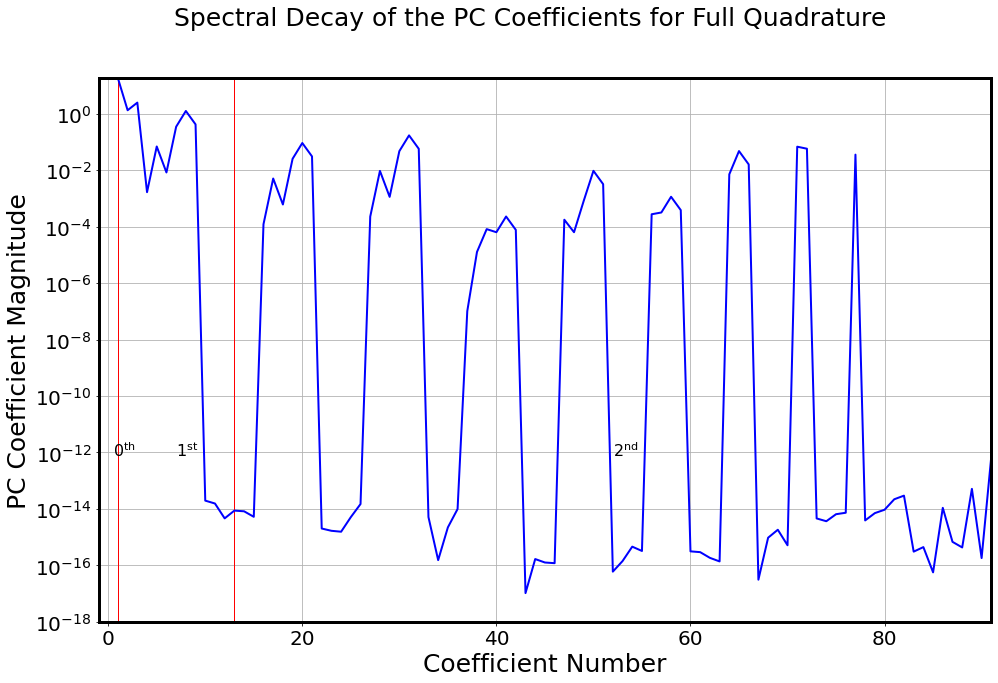


Multi_Index_Dim_Sparse.pdf has been saved.


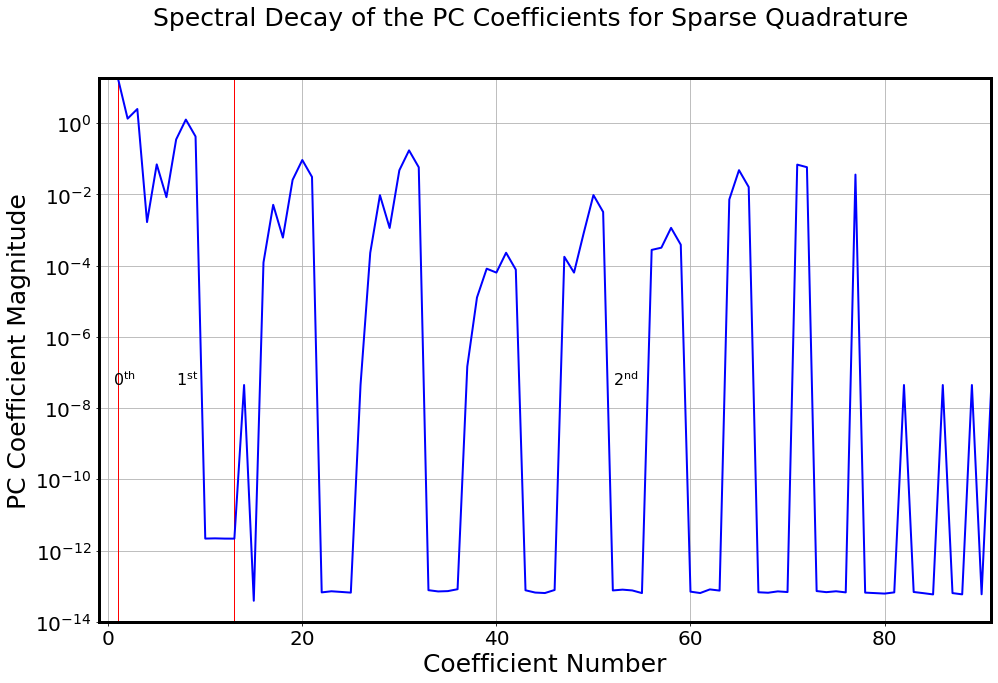


heat_flux_pce.pdf has been saved.


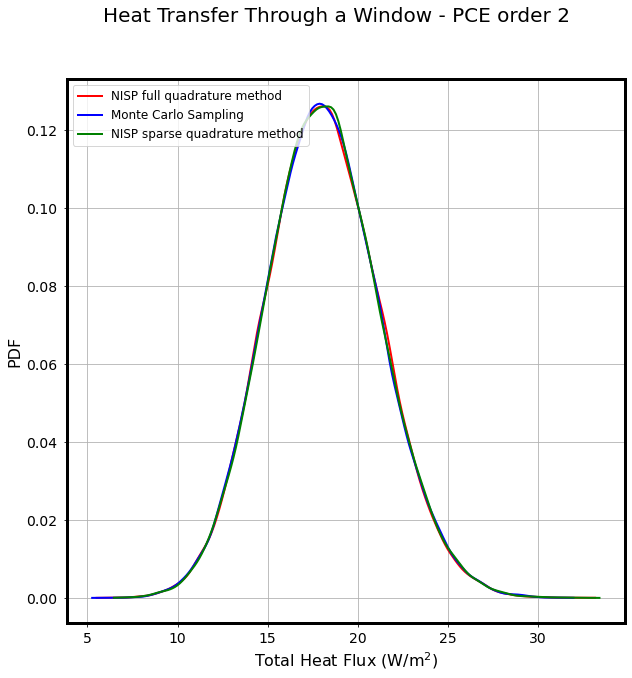

In [10]:
# Print statements to indicate number of samples used
print("\nMonte Carlo sampling used %s points" %(n_MC))
print("Full quadrature method used %s points" %(totquat))
print("Sparse quadrature method used %s points" %(totquat2))

#Plots showing the spectral decay of the PC coefficient magnitude in relation PC order.
pce_tools.UQTkPlotMiDims(pc_model,c_k,ndim, nord, "Full")
pce_tools.UQTkPlotMiDims(pc_model2,c_k2,ndim, nord, "Sparse")

# Plot the three PDF curves on the same figure
plt.figure(figsize=(10,10))
plt.plot(xpts_pce, PDF_data_pce, linewidth=2, color='r', label='NISP full quadrature method')
plt.plot(xpts_MC, PDF_data_MC, linewidth=2, color='b', label='Monte Carlo Sampling')
plt.plot(xpts_pce2, PDF_data_pce2, linewidth=2, color='g', label= 'NISP sparse quadrature method')

# Label axes
plt.xlabel("Total Heat Flux ($W/m^2$)", size=16)
plt.ylabel("PDF", size=16)
# Add title
plt.suptitle("Heat Transfer Through a Window - PCE order %s"%(nord), size=20)
# Change tick size
plt.tick_params(axis='both', labelsize=14)
# Pad tick labels
plt.gca().tick_params(pad=6)
# Create legend
plt.legend(loc='upper left', prop={'size':12})
# Save figure
fig_name="heat_flux_pce.pdf"
plt.savefig(fig_name)
print("\nheat_flux_pce.pdf has been saved.")
# Show figure
plt.show()

# Map2PCE

In [ ]:
# Instantiate PC Object with sparse quadrature methods
pc_model2 = uqtkpce.PCSet("NISPnoq", nord,ndim,pc_type, pc_alpha,pc_beta)
pc_model2.SetQuadRule(pc_type, 'sparse', param)

#Get NumPy array of quadrature points
qdpts2, totquat2= pce_tools.UQTkGetQuadPoints(pc_model2)

# Convert Quadrature points in ξ_i to equivalent samples of input parameters
samples2=[0]*ndim
for p_i in range(ndim):
    samples2[p_i]=p[p_i]+std_p[p_i]*qdpts2[:,p_i]
samples2=np.array(samples2)
c_k=pce_tools.UQTkMap2PCE(pc_model2,samples2,verbose=0)

# Generate germ samples
germ_samples2=np.random.normal(0,1, (n_MC,ndim))

# Evaluate the PCE at the germ samples
pce_evals2=pce_tools.UQTkEvaluatePCE(pc_model2,c_k2,germ_samples2)

#Peform kernel density estimation
xpts_pce2, PDF_data_pce2= pce_tools.UQTkKDE(pce_evals2)